In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset

import torch
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd 

import os
import sys
sys.path.append(os.getcwd()+"/../..")

from src import paths

import tqdm

from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [3]:
# Load data
data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)

# Number of labels
num_labels = len(set(df['train']['labels']))

# Label to id
label2id = {'primary_progressive_multiple_sclerosis': 0,
            'relapsing_remitting_multiple_sclerosis': 1,
            'secondary_progressive_multiple_sclerosis': 2}
id2label = {v:k for k,v in label2id.items()}

In [5]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/'medbert')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Load model
model = AutoModelForSequenceClassification.from_pretrained(paths.MODEL_PATH/'ms_diag_medbert_valloss', num_labels=num_labels).to(device)

In [8]:
BATCH_SIZE = 16
def prepare_data(data):
    
    # Label
    data['labels'] = [label2id[label] for label in data['labels']]

    # Tokenize
    data = tokenizer(data['text'], padding=True, truncation=True, return_tensors='pt', max_length = 256)

    return data

# Tokenize dataset
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors='pt')
dataset = df.map(prepare_data, batched=True, remove_columns=['rid', 'text', 'date'], batch_size=512)

#Test Loader
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

100%|██████████| 4/4 [00:00<00:00, 10.71it/s]


F1 Score: 0.9101307189542484
Precision: 0.8666666666666667
Recall: 0.9871794871794872


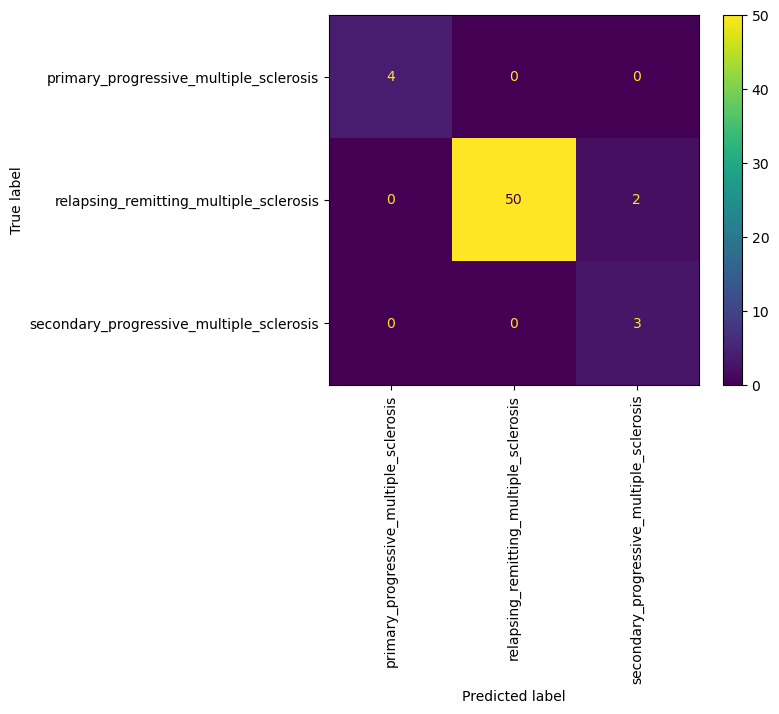

In [22]:
# Predictions
predictions = []
labels = []
last_hidden_states = []
#f1_test = evaluate.load("f1")
for batch in tqdm.tqdm(test_loader):
    with torch.no_grad():
        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch, output_hidden_states = True)
        last_hidden_state = last_hidden_states.append(outputs.hidden_states[-1])
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        #f1_test.add_batch(predictions=preds, references=batch['labels'])
        predictions.extend(preds.tolist())
        labels.extend(batch['labels'].tolist())

from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# f1 score, precision, recall
print(f"F1 Score: {f1_score(labels, predictions, average='macro')}")
print(f"Precision: {precision_score(labels, predictions, average='macro')}")
print(f"Recall: {recall_score(labels, predictions, average='macro')}")
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(labels, predictions, display_labels=list(id2label.values()), xticks_rotation='vertical')

# Saving test stuff
pd.DataFrame({"labels": labels, "predictions": predictions}).to_csv(paths.RESULTS_PATH/"ms-diag"/"ms-diag_medbert-finetuned-artif.csv", index=False)
embeddings = torch.cat(last_hidden_states, dim = 0)
torch.save(embeddings, paths.RESULTS_PATH/"ms-diag"/"ms-diag_medbert-finetuned-artif.pt")

In [12]:
import pandas as pd
df_test = pd.read_csv(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag/ms-diag_clean_test.csv'))
for i, label in enumerate(labels):
    if label != predictions[i]:
        print("Entry: ", i)
        print("Label", id2label[label])
        print("Predicted", id2label[predictions[i]])
        print("Text: ", df_test.iloc[i]["text"])
        print("\n")

Entry:  3
Label relapsing_remitting_multiple_sclerosis
Predicted secondary_progressive_multiple_sclerosis
Text:  Schubförmige Multiple Sklerose mit V. a. sekundär chronisch progredienten Verlauf seit ca. 2016, EM 1997, ED 2003, EDSS 6.0 klinisch: nicht aktiv; radiologisch: nicht aktiv; Progression: nein (Lublin, 2013) aktuell: spastische ataktische Gangstörung beinbetont rechts, distal- und beinbetontes motorisches Hemisyndrom rechts, 6Min Gehtest 460m Verlauf:  INDENT 05/ 1997 1.Schub mit beidseitiger Visusminderung, vollständige Rückbildung INDENT 2003 - 2007 alle 1.5 - 2 Jahre ein Schub (motorische Störung der Beine), starke Depression  INDENT 2007 - 2014 mehrere Schübe unter Copaxone (Schubrate nicht bekannt)  INDENT 09/2014: Schub mit Gangunsicherheit und Parese des rechten Beines, Koordinationsstörungen der rechten Hand (inkomplette Regression der Parese des rechten Beines)  INDENT 11/2016 Progression der Steifigkeit und Ermüdbarkeit der rechten Bein in Vergleich zu vergangenen J

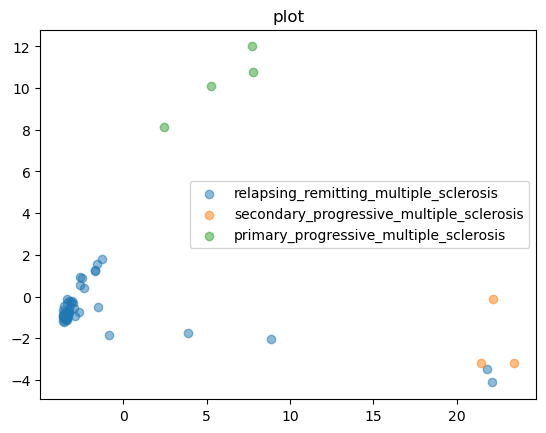

In [25]:
def plot_embeddings(embeddings: torch.tensor, labels:list, title = "plot", method="pca", aggregation="mean"):
    """
    Plot embeddings using PCA or UMAP
    """

    # Create a PCA object
    if method == "umap":
        reducer = umap.UMAP()
    elif method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=5, n_iter=250)
    else:
        raise ValueError("Reducer Method not implemented")

    # Aggregate embeddings along sequence dimension
    if aggregation == "mean":
        embeddings = torch.mean(embeddings, dim=1)
    elif aggregation == "cls":
        embeddings = embeddings[:,0,:]
    else:
        raise ValueError("Aggregation method not implemented")

    # Fit and transform the embeddings using the PCA object
    principalComponents = reducer.fit_transform(embeddings)

    # Create a dataframe with the embeddings and the corresponding labels
    df_embeddings = pd.DataFrame(principalComponents, columns=['x', 'y'])
    df_embeddings['label'] = labels
    
    for label in df_embeddings['label'].unique():
        _df = df_embeddings[df_embeddings['label'] == label]
        plt.scatter(_df['x'], _df['y'], alpha=0.5)
        plt.legend(df_embeddings['label'].unique())

    # Add a title and show the plot
    plt.title(title)

    plt.show()

plot_embeddings(embeddings.to("cpu"), labels = [id2label[label] for label in labels])